# Replay in Aversive Environments - Sequenceness analysis

#### _This is a template that will be parameterised and run via [Papermill](http://papermill.readthedocs.io/) for each subject_

This notebook uses the classifer trained on the localiser data to detect spontaneous state reactivation during the planning and rest phases of the task.

Analysis steps:

1. Loading task data and classifier
2. Applying the classifer to the task data to generate time X state reactivation probabilities matrices
3. Running the GLM-based sequenceness estimation procedure

## Imports

In [1]:
import os
os.chdir('..')
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, 'code')
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.externals import joblib
import os
import papermill as pm
from state_prediction import *
from sequenceness import *
from utils import *
%matplotlib inline

np.random.seed(100)

## Parameters

In [2]:
# DEFAULT PARAMETERS - OVERRRIDEN BY PAPERMILL EXECUTION
session_id = 'e003'  # ID of the scanning session
output_dir = 'data/derivatives'  # Where the output data should go
eye_tracking = True  # If True, eye-tracking measures will be used for exclusion of blink-related ICA components
n_stim = 8  # Number of stimuli, including null
shifts = [-5, 6]  # Additional timepoints to use as features
max_lag = 40  # Maximum lag to use in sequencess analysis

## Ensure state stimuli match up between localiser and task

Due to incompetence on my part, the stimuli used for the localiser and task have different indices (e.g. stimulus 1 for the localiser may be a house while stimulus 1 for the task may be a cat). The tasks output the order of stimuli used however so all we need to do is match the two.

In [ ]:
# subject_ids = pd.read_csv('subject_ids.csv', sep='\t')
# behavioural_id = subject_ids.loc[subject_ids['meg'] == session_id]['behavioural'].values[0]
# localiser_stimuli_file = os.path.join('localiser/Data', [i for i in os.listdir('localiser/Data') if behavioural_id in i and 'stimuli' in i][0])
# task_stimuli_file = os.path.join('task/Data/behavioural/logs', [i for i in os.listdir('task/Data/behavioural/logs') if behavioural_id in i and 'stimuli' in i][0])

In [ ]:
# def get_stimuli(log_file):
#     with open(log_file, 'r') as f:
#         stimuli = f.read().split(',')
#     stimuli = [re.search('[0-9]{2}', i).group() for i in stimuli]
#     return stimuli

# def match_stimuli(localiser, task):
#     localiser_stimuli = get_stimuli(localiser)
#     task_stimuli = get_stimuli(task)
#     print(localiser_stimuli, task_stimuli)
#     new_idx = [localiser_stimuli.index(i) for i in task_stimuli]
#     return new_idx

# # This returns the correct indices for the task stimuli
# correct_idx = match_stimuli(localiser_stimuli_file, task_stimuli_file) + [7]

## State detection

### Load the classifier

First we load the classifier that we previously trained on the localiser data

In [3]:
clf = joblib.load(os.path.join(output_dir, 'classifier', 'sub-{0}_classifier.pkl').format(session_id)) 

### Get the task data

We're interested in the planning and rest phases so we'll select these.

In [4]:
task_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing/task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-task_proc_ICA-epo.fif.gz').format(session_id))
planning_epochs = task_epochs['planning']
rest_epochs = task_epochs['rest']

# Get the data as a numpy array, excluding non-MEG channels
picks_meg = mne.pick_types(task_epochs.info, eeg=True)
planning_X = planning_epochs.get_data()[:, picks_meg, :] # MEG signals: n_epochs, n_channels, n_times
rest_X = rest_epochs.get_data()[:, picks_meg, :]

Reading data/derivatives\preprocessing/task\sub-e003_ses-01_task-AversiveLearningReplay_run-task_proc_ICA-epo.fif.gz ...
    Found the data of interest:
        t =       0.00 ...    5990.00 ms
        0 CTF compensation matrices available
197 matching events found
Applying baseline correction (mode: mean)
197 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [5]:
assert np.isnan(planning_X).any() == False, "Nans present in planning data"
assert np.isnan(rest_X).any() == False, "Nans present in rest data"
assert np.isinf(planning_X).any() == False, "Infs present in planning data"
assert np.isinf(rest_X).any() == False, "Infs present in rest data"

### State detection

Here we iterate over trials, reshape the data for each trial into the format `[n_trials, n_sensors, n_timepoints]`, where the first dimension is 1 and the final dimension is the timepoint of interest plus additional adjacent timepoints used as extra features, and finally and use the `predict_proba` method of the fitted classifier to get predicted state reactivation probabilities for every timepoint within the trial.


This involves a lot of for loops and could probably be made far more efficient...

In [9]:
planning_state_reactivation = predict_states(planning_X, clf, shifts=shifts)
assert np.isnan(planning_state_reactivation).any() == False, "Nans present in planning state reactivation array"
assert np.isinf(planning_state_reactivation).any() == False, "Infs present in planning state reactivation array"

rest_state_reactivation = predict_states(rest_X, clf, shifts=shifts)
assert np.isnan(rest_state_reactivation).any() == False, "Nans present in rest state reactivation array"
assert np.isinf(rest_state_reactivation).any() == False, "Infs present in rest state reactivation array"

In [15]:
# Put the stimuli in the right order
# planning_state_reactivation = planning_state_reactivation[..., correct_idx]
# rest_state_reactivation = rest_state_reactivation[..., correct_idx]

# Save state probabilities
np.save(os.path.join(output_dir, 'state_reactivation_arrays', 'planning', 'sub-{0}_planning_state_reactivation'.format(session_id)), planning_state_reactivation)
np.save(os.path.join(output_dir, 'state_reactivation_arrays', 'rest', 'sub-{0}_rest_state_reactivation'.format(session_id)), rest_state_reactivation)

# Convert to StateReactivation class
rest_state_reactivation = StateReactivation(rest_state_reactivation)
planning_state_reactivation = StateReactivation(planning_state_reactivation)

## Sequenceness analysis

After determining the state reactivation probabilities for each trial, we can submit this data to the sequenceness analysis. We use a GLM approach here.

### Load transition matrix

Here we load the transition matrix of the task, which is necessary for sequenceness analysis. We then subset this matrix to get the two branches of the task tree.

In [18]:
transition_matrix = np.loadtxt(r'../MEG/task/Task_information/transition_matrix.txt')

matrices = [transition_matrix]

# Select individual arms
for n, i in enumerate([5, 6]):
    matrices.append(select_path(transition_matrix, i))

# Cross-state transitions for each stage
# cross_state_0 = np.zeros((7, 7))
# cross_state_0[1, 2] = 1
# cross_state_1 = np.zeros((7, 7))
# cross_state_1[3, 4] = 1
# cross_state_2 = np.zeros((7, 7))
# cross_state_2[5, 6] = 1
    
# matrices = matrices + [cross_state_0, cross_state_1, cross_state_2]

# plot_matrices(matrices)

### Run the analysis for each trial

This returns a dictionary with entries representing forwards and reverse sequenceness, along with the difference between the two.

This is repeated for 1000 permuted transition matrices that share no transitions with the true matrix or its inverse.

In [31]:
rest_sequenceness, null_rest_sequenceness = rest_state_reactivation.get_sequenceness(40, matrices, remove_first=True, constant=False, set_zero=True)
planning_sequenceness, null_planning_sequenceness = planning_state_reactivation.get_sequenceness(40, matrices, remove_first=True, constant=False, set_zero=True)

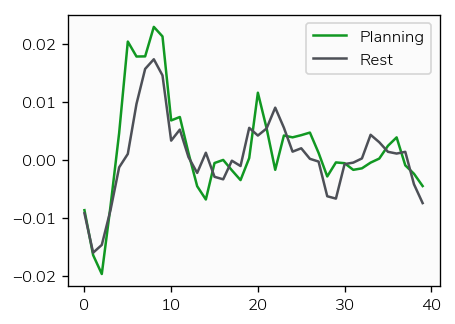

In [51]:
plt.figure(dpi=120, figsize=(4, 3))
pal = ['#119822', '#4d5057']
plt.plot(planning_sequenceness['difference'][..., 0].mean(axis=0), color=pal[0], label='Planning')
plt.plot(rest_sequenceness['difference'][..., 0].mean(axis=0), color=pal[1], label='Rest')
plt.legend()
plt.savefig('eeg_replay.svg')
plt.savefig('eeg_replay.png')

## Save the sequenceness data

In [ ]:
joblib.dump(planning_state_reactivation, os.path.join(output_dir, 'sequenceness', 'planning', 'sub-{0}_planning_sequenceness.pkl'.format(session_id)))
joblib.dump(rest_state_reactivation, os.path.join(output_dir, 'sequenceness', 'rest', 'sub-{0}_rest_sequenceness.pkl'.format(session_id)))

## Outcome reactivation

Load the classifier

In [ ]:
outcome_clf = joblib.load(os.path.join(output_dir, 'classifier', 'sub-{0}_outcome_classifier.pkl').format(session_id)) 

Predict outcome reactivations for planning, rest, and final state

In [ ]:
final_state_epochs = mne.read_epochs(os.path.join(output_dir, 'preprocessing/task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-task_final_state_proc_ICA-epo.fif.gz').format(session_id))
final_state_X = final_state_epochs.get_data()[:, picks_meg, :]

In [ ]:
rest_outcome_reactivation = predict_states(rest_X, outcome_clf, n_stim=3)
planning_outcome_reactivation = predict_states(planning_X, outcome_clf, n_stim=3)
final_state_outcome_reactivation = predict_states(final_state_X, outcome_clf, n_stim=3)

In [ ]:
# Save state probabilities
np.save(os.path.join(output_dir, 'outcome_reactivation_arrays', 'planning', 'sub-{0}_planning_outcome_reactivation'.format(session_id)), planning_outcome_reactivation)
np.save(os.path.join(output_dir, 'outcome_reactivation_arrays', 'rest', 'sub-{0}_rest_outcome_reactivation'.format(session_id)), rest_outcome_reactivation)
np.save(os.path.join(output_dir, 'outcome_reactivation_arrays', 'final_state', 'sub-{0}_final_state_outcome_reactivation'.format(session_id)), final_state_outcome_reactivation)